In [1]:
import os, json
from PIL import Image
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import models 

# ----
from data.dataset import FoodImageDataset
import custom_models

In [2]:
torch.cuda.is_available()

True

In [23]:
df_train = pd.DataFrame({"filename":os.listdir("../../train")})
df_val = pd.DataFrame({"filename":os.listdir("../../val")})

def get_class(filename):
    info = filename.split("-")
    return info[1]

df_train["class"] = df_train["filename"].apply(lambda x: get_class(x))
df_val["class"] = df_val["filename"].apply(lambda x: get_class(x))



names = []
for i in df_val["class"].unique(): 
    if i not in df_train["class"].unique():
        names.append(i)

print(len(names))

df_val["class"].value_counts()

24


class
apple_pie        250
miso_soup        250
peking_duck      250
panna_cotta      250
pancakes         250
                ... 
donuts           250
deviled_eggs     250
cup_cakes        250
croque_madame    250
waffles          250
Name: count, Length: 101, dtype: int64

In [ ]:
import logging
from datetime import datetime

# 配置日志
logging.basicConfig(
    filename=f'training_{datetime.now().strftime("%Y%m%d_%H%M%S")}.log',
    level=logging.INFO,
    format='%(asctime)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# 记录超参数
params = {
    'batch_size': 32,
    'lr': 0.001,
    'epochs': 10
}
logging.info(f"Hyperparameters: {params}")

# 模拟训练循环
for epoch in range(params['epochs']):
    train_loss = 0.1 * (0.9 ** epoch)  # 示例损失
    val_loss = 0.2 * (0.9 ** epoch)
    logging.info(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")

In [ ]:
df = pd.DataFrame({"file_name": os.listdir("../../val")})

def process(file_name):
    info = file_name.split("-")
    return info[1] if len(info) == 3 else info
df['class'] = df['file_name'].apply(lambda x: process(x))
df['class'].value_counts()

In [ ]:
config = json.load(open('./config.json'))
mapping = json.load(open('./mapping.json'))
config

In [ ]:
train_foodimages = FoodImageDataset(config["dataset"]["train_path"])
val_foodimages = FoodImageDataset(config["dataset"]["val_path"])
train_loader = DataLoader(train_foodimages, batch_size=config["train"]["batch_size"], shuffle=True)
val_loader = DataLoader(val_foodimages, batch_size=config["train"]["batch_size"], shuffle=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [ ]:
# 训练函数
def train_model(model, train_loader, val_loader):
    # 根据配置文件定义超参数
    lr = config["train"]["lr"]
    num_epochs = config["train"]["num_epochs"]
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"using {device}")
    
    # 移动模型到指定设备
    model = model.to(device)
    
    # 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr)
    
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            # 前向传播
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # 统计
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels.max(1)[1]).sum().item()
        
        train_acc = 100. * train_correct / train_total
        
        # 验证阶段
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        val_acc = 100. * val_correct / val_total
        
        
        # 保存最佳模型
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
        
        # 打印训练信息
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%')
        print('--------------------')
        
model = custom_models.FRM_20250213_1()
train_model(model, train_loader, val_loader)

In [13]:
import json
config = json.load(open('./config.json'))

for k, v in config.items():
    print(k)
    for kk, vv in v.items():
        print(f"--{kk}: {vv}")


model
--name: resnet50
--num_classes: 101
dataset
--train_path: ../../train
--val_path: ../../val
train
--batch_size: 32
--lr: 0.001
--num_epochs: 10


In [7]:
import os, json
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from IPython.display import Image as ipython_Image

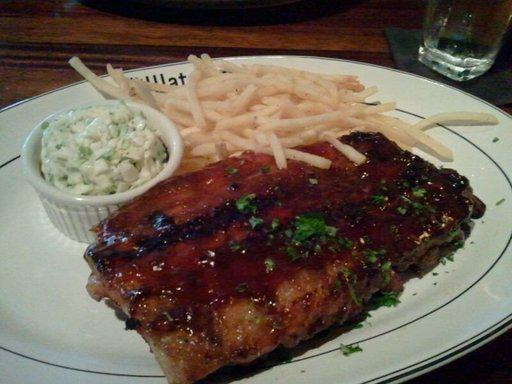

In [ ]:


train_img_path = "../dataset/train"

test_img_path = os.path.join(train_img_path, os.listdir(train_img_path)[0])



ipython_Image(filename=test_img_path) 

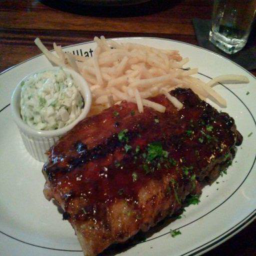

In [12]:
Image.open(test_img_path).convert('RGB')

transform = transforms.Compose([
                transforms.Resize((256, 256)),
            ])
new_img = transform(Image.open(test_img_path))

new_img

In [12]:
import os, json

config = json.load(open('./config.json'))


dict(zip(set(i.split("-")[1] for i in os.listdir(config["dataset"]["train_path"])), range(config["model"]["num_classes"])))

{'lasagna': 0,
 'prime_rib': 1,
 'club_sandwich': 2,
 'ice_cream': 3,
 'gnocchi': 4,
 'sushi': 5,
 'french_toast': 6,
 'cheesecake': 7,
 'greek_salad': 8,
 'pad_thai': 9,
 'bread_pudding': 10,
 'spaghetti_carbonara': 11,
 'lobster_bisque': 12,
 'samosa': 13,
 'french_fries': 14,
 'nachos': 15,
 'beef_carpaccio': 16,
 'donuts': 17,
 'carrot_cake': 18,
 'baby_back_ribs': 19,
 'peking_duck': 20,
 'foie_gras': 21,
 'pulled_pork_sandwich': 22,
 'scallops': 23,
 'grilled_salmon': 24,
 'waffles': 25,
 'spring_rolls': 26,
 'guacamole': 27,
 'deviled_eggs': 28,
 'red_velvet_cake': 29,
 'shrimp_and_grits': 30,
 'edamame': 31,
 'pancakes': 32,
 'bruschetta': 33,
 'churros': 34,
 'escargots': 35,
 'baklava': 36,
 'grilled_cheese_sandwich': 37,
 'steak': 38,
 'garlic_bread': 39,
 'fried_calamari': 40,
 'mussels': 41,
 'caprese_salad': 42,
 'sashimi': 43,
 'oysters': 44,
 'fried_rice': 45,
 'ceviche': 46,
 'beef_tartare': 47,
 'eggs_benedict': 48,
 'fish_and_chips': 49,
 'clam_chowder': 50,
 'seawee

In [10]:
set(i.split("-")[1] for i in os.listdir(config["dataset"]["train_path"]))

{'apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [4]:
import os, json

config = json.load(open('./config.json'))

if not config["train"]["use_wandb"]:
    print(1)

1
